In [1]:
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import matplotlib.pyplot as plt


In [2]:
iris = sns.load_dataset('iris')


In [3]:
data = torch.tensor(iris[iris.columns[0:4]].values).float()
labels = torch.zeros(len(data),dtype=torch.long )
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica'] = 2

# Cross validation using Numpy

In [4]:
proptraining =.8
ntraining= int(len(labels)*proptraining)
traintestbool = np.zeros(len(labels),dtype =bool)
item2use4train = np.random.choice(range(len(labels)),ntraining,replace = False)
traintestbool[item2use4train] = True
traintestbool

array([ True,  True, False,  True,  True, False,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True, False,  True, False,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False, False,  True,  True,  True,  True, False,  True,  True,
        True, False,  True,  True, False,  True, False, False,  True,
       False, False, False, False, False, False,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [5]:
print('Average of full data:')
print(torch.mean(labels.float()))
print(' ')
print('Average of training data:')
print(torch.mean(labels[traintestbool].float()))
print(' ')
print('Average of test data:')
print(torch.mean(labels[~traintestbool].float()))


Average of full data:
tensor(1.)
 
Average of training data:
tensor(1.)
 
Average of test data:
tensor(1.)


In [6]:
ANNiris = nn.Sequential(
    nn.Linear(4,64),
    nn.ReLU(),
    nn.Linear(64,64),
    nn.ReLU(),
    nn.Linear(64,3)
)
lossfun = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(ANNiris.parameters(),lr = 0.01)

In [7]:
numepochs = 1000
losses = torch.zeros(numepochs)
ongoingAcc = []
for epochi in range(numepochs):
 yHat = ANNiris(data[traintestbool,:])
 ongoingAcc.append(100*torch.mean((torch.argmax(yHat,axis= 1)==labels[traintestbool]).float()))
 loss = lossfun(yHat,labels[traintestbool])
 losses[epochi] = loss
 optimizer.zero_grad()
 loss.backward()
 optimizer.step()

In [8]:
predictions = ANNiris(data[traintestbool,:])
trainacc =100*torch.mean((torch.argmax(predictions,axis = 1)==labels[traintestbool]).float())
predictions = ANNiris(data[~traintestbool,:])
testacc = 100*torch.mean((torch.argmax(predictions,axis = 1)==labels[~traintestbool]).float())

In [9]:
print('Final Train accuracy:%g%%'%trainacc)
print('Final Test accuracy:%g%%'%testacc)

Final Train accuracy:98.3333%
Final Test accuracy:93.3333%


# Cross Validation using Scikit Learn

In [10]:
from sklearn.model_selection import train_test_split


In [11]:
def createANNmodel():
  ANNiris = nn.Sequential(
      nn.Linear(4,64),
      nn.ReLU(),
      nn.Linear(64,64),
      nn.ReLU(),
      nn.Linear(64,3)
    )
  lossfun = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(ANNiris.parameters(),lr = 0.01)
  return ANNiris,lossfun,optimizer

In [12]:
numepochs = 200
def trainmodel(trainprop):
  losses = torch.zeros(numepochs)
  trainacc = []
  testacc = []
  x_train,x_test,y_train,y_test = train_test_split(data,labels,train_size=trainprop)
  for epochi in range(numepochs):

    yHat = ANNiris(x_train)
    loss = lossfun(yHat,y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    trainacc.append(100*torch.mean((torch.argmax(yHat,axis=1)==y_train).float()).item())
    predlabels= torch.argmax(ANNiris(x_test),axis= 1)
    testacc.append(100*torch.mean((predlabels==y_test).float()).item())
  return trainacc,testacc

In [13]:
ANNiris,lossfun,optimizer = createANNmodel()
trainacc,testacc = trainmodel(.8)

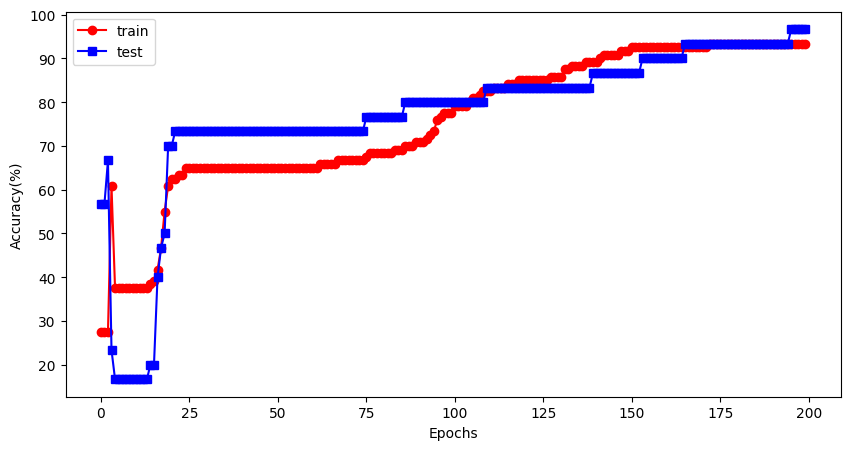

In [14]:
fig = plt.figure(figsize = (10,5))
plt.plot(trainacc,'ro-')
plt.plot(testacc,'bs-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy(%)')
plt.legend(['train','test'])


In [15]:
trainsetsizes = np.linspace(.2,.95,10)
alltrainacc = np.zeros((len(trainsetsizes),numepochs))
alltestacc = np.zeros((len(trainsetsizes),numepochs))
for i in range(len(trainsetsizes)):
  ANNiris,lossfun,optimizer = createANNmodel()
  trainacc,testacc = trainmodel(trainsetsizes[i])
  alltrainacc[i,:] = trainacc
  alltestacc[i,:] = testacc

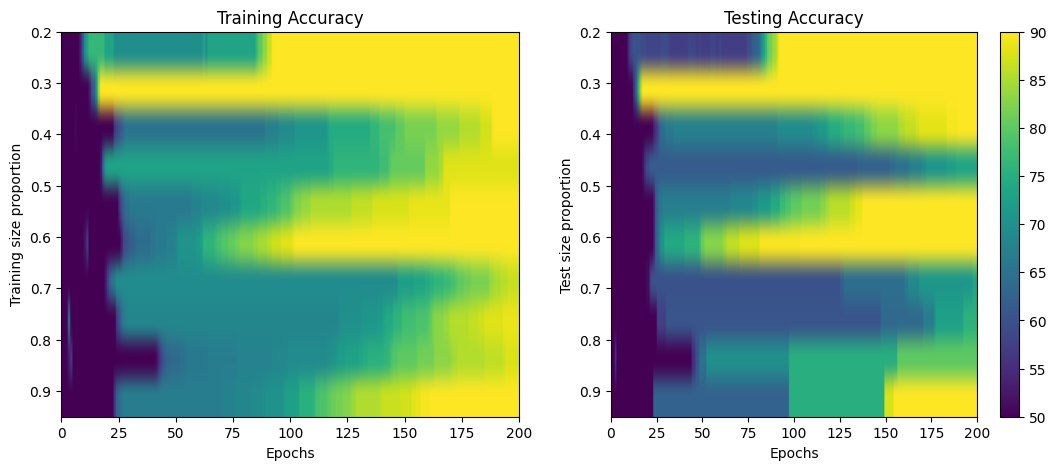

In [16]:
fig,ax = plt.subplots(1,2,figsize=(13,5))
ax[0].imshow(alltrainacc,aspect='auto',
             vmin=50,vmax=90,extent=[0,numepochs,trainsetsizes[-1],trainsetsizes[0]])
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Training size proportion')
ax[0].set_title('Training Accuracy')

p= ax[1].imshow(alltestacc,aspect='auto',
             vmin=50,vmax=90,extent=[0,numepochs,trainsetsizes[-1],trainsetsizes[0]])
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Test size proportion')
ax[1].set_title('Testing Accuracy')
fig.colorbar(p,ax=ax[1])

# Cross Validation Using DataLoader

In [18]:
from torch.utils.data import DataLoader,TensorDataset


In [20]:
train_data,test_data,train_labels,test_labels = \
                                      train_test_split(data,labels,train_size= .8)
train_data =TensorDataset(train_data,train_labels)
test_data = TensorDataset(test_data,test_labels)
train_loader = DataLoader(train_data,shuffle=True,batch_size= 12)
test_loader = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [22]:
for x,y in train_loader:
  print(x.shape,y.shape)
x,y

torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])


(tensor([[7.1000, 3.0000, 5.9000, 2.1000],
         [5.5000, 2.6000, 4.4000, 1.2000],
         [4.6000, 3.4000, 1.4000, 0.3000],
         [4.6000, 3.2000, 1.4000, 0.2000],
         [5.1000, 2.5000, 3.0000, 1.1000],
         [5.1000, 3.3000, 1.7000, 0.5000],
         [5.6000, 3.0000, 4.1000, 1.3000],
         [5.4000, 3.4000, 1.5000, 0.4000],
         [6.0000, 2.2000, 5.0000, 1.5000],
         [5.7000, 3.8000, 1.7000, 0.3000],
         [5.8000, 2.7000, 5.1000, 1.9000],
         [6.4000, 2.8000, 5.6000, 2.1000]]),
 tensor([2, 1, 0, 0, 1, 0, 1, 0, 2, 0, 2, 2]))

In [23]:
def createANewmodel():
  ANNiris = nn.Sequential(
      nn.Linear(4,64),
      nn.ReLU(),
      nn.Linear(64,64),
      nn.ReLU(),
      nn.Linear(64,3)
    )
  lossfun = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(ANNiris.parameters(),lr = 0.01)
  return ANNiris,lossfun,optimizer

In [25]:
numepochs = 500
def trainmodel():
  trainAcc =[]
  testAcc = []
  for epochi in range(numepochs):
    batchAcc = []
    for x,y in train_loader:
      yHat = ANNiris(x)
      loss = lossfun(yHat,y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      batchAcc.append(100*torch.mean((torch.argmax(yHat,axis=1)==y).float()).item())
    trainAcc.append(np.mean(batchAcc))
    x,y = next(iter(test_loader))
    predlabels = torch.argmax(ANNiris(x),axis=1)
    testAcc.append(100*torch.mean((predlabels==y).float()).item())
  return trainAcc,testAcc

In [26]:
ANNiris,lossfun,optimizer= createANewmodel()
trainAcc,testAcc = trainmodel()

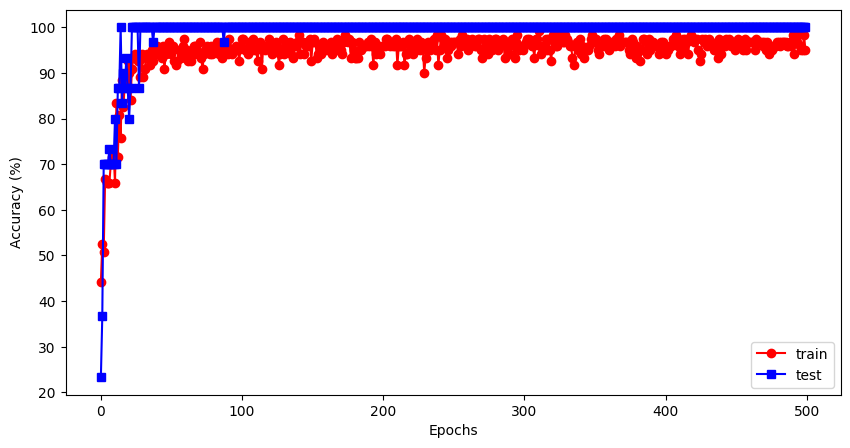

In [27]:
fig = plt.figure(figsize = (10,5))
plt.plot(trainAcc,'ro-')
plt.plot(testAcc,'bs-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['train','test'])
